# Redes neuronales: red feed-forward

Se considera el dataset Fashion-MNIST1, un conjunto de datos con imágenes de 10 tipos diferentes de
artículos de la empresa de vestimenta Zalando, con 60.000 instancias de entrenamiento y 10.000
de evaluación. Cada imagen en escala de gris del dataset tiene un tamaño de 28x28 píxeles y
asociada a cada una existe una etiqueta entera en el rango 0-10, representando cada categoría.

### A continuación, se construirá un clasificador base:
#### Se trata de una red neuronal feedforward con una capa oculta de 32 unidades. Se utiliza la función sigmoide como función de activación y la red devolverá, para una imagen de entrada, una distribución de probabilidad sobre las categorías y con esta se le asigna a la imagen la categoría más probable.

In [ ]:
# Importaciones necesarias
import numpy as np
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

#####Se importan los datos de MNIST

In [ ]:
image_path = './'

# Esto nos permite convertir las features de los píxeles en tensores y los normaliza al rango [0,1]
transform = transforms.Compose([transforms.ToTensor()])

# Importamos los datasets
# Las etiquetas son valores entre 0 y 9 para representar los dígitos.
fashionmnist_train_dataset = torchvision.datasets.FashionMNIST(root=image_path, train=True, transform=transform, download=True)
fashionmnist_test_dataset  = torchvision.datasets.FashionMNIST(root=image_path, train=False, transform=transform, download=True)

#####Se divide el conjunto de entrenamiento en conjuntos de entrenamiento y validación

In [ ]:
fashionmnist_train, fashionmnist_val = train_test_split(fashionmnist_train_dataset, test_size=0.2, random_state=0)

# Se imprime el tamaño de cada conjunto para observar que esté bien distribuido
print('Tamaño del conjunto de entrenamiento: ', len(fashionmnist_train))
print('Tamaño del conjunto de validación: ', len(fashionmnist_val))
print('Tamaño del conjunto de testeo: ', len(fashionmnist_test_dataset))

Tamaño del conjunto de entrenamiento:  48000
Tamaño del conjunto de validación:  12000
Tamaño del conjunto de testeo:  10000


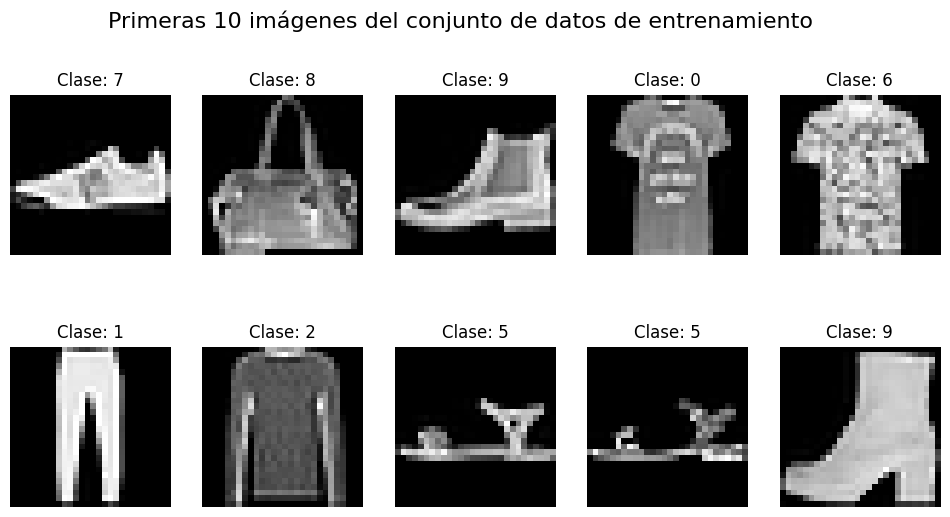

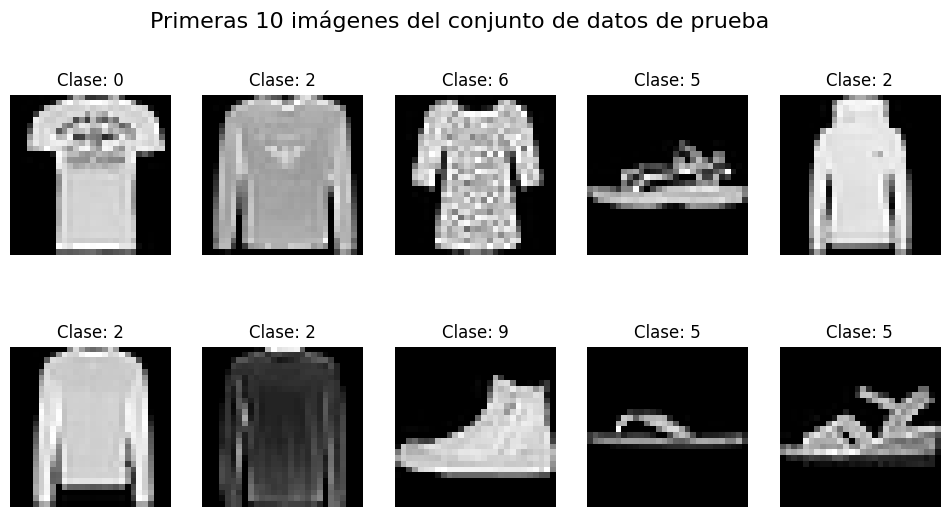

In [ ]:
# Vemos las primeras 10 imágenes de cada dataset
def primeras10instancias(dataset, train_test):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle(f"Primeras 10 imágenes del conjunto de datos {train_test}", fontsize=16)
    for i in range(10):
        image, label = dataset[i]
        ax = axes[i // 5, i % 5]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(f'Clase: {label}')
        ax.axis('off')
    plt.show()

primeras10instancias(fashionmnist_train, "de entrenamiento")
primeras10instancias(fashionmnist_val, "de prueba")

In [ ]:
# Utilizamos DataLoader para construir un iterable con batch_size = 64 (cada lote tiene 64 instancias)
batch_size = 64
torch.manual_seed(10)
train_dl = DataLoader(fashionmnist_train, batch_size, shuffle=True)
val_dl = DataLoader(fashionmnist_val, batch_size, shuffle=True)

#####Definición del modelo

In [ ]:
cantidad_categorias = 10
image_size = fashionmnist_train_dataset[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]

# Se crea el modelo base
hidden_units = 32

# Nuestro primer paso es convertir las imágenes a un vector
all_layers = [nn.Flatten()]

# Creamos la capa oculta
layer = nn.Linear(input_size, hidden_units)
all_layers.append(layer)

# Agregamos la función de activación sigmoide
all_layers.append(nn.Sigmoid())

# Agregamos la capa de salida
all_layers.append(nn.Linear(hidden_units,cantidad_categorias))

# Construimos el modelo
model = nn.Sequential(*all_layers)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=32, out_features=10, bias=True)
)


####Pasamos a entrenar el modelo base durante 10 épocas, utilizando descenso por gradiente estocástico y una tasa de aprendizaje de 0.01
#####Para esto, se crea función de entrenamiento para poder utilizarla más adelante. 
Esta función, además de realizar el entrenamiento, prueba y calcula el accuracy para el dataset de validación para cada época, luego de realizado el entrenamiento.
Además, guarda y retorna en una lista los valores de la función de pérdida y accuracy obtenidos para ser analizados luego.

In [ ]:
def train(model, num_epochs, tasa_aprendizaje):

  optimizer = torch.optim.SGD(model.parameters(), lr=tasa_aprendizaje)
  loss_fn = nn.CrossEntropyLoss()
  torch.manual_seed(10)

  # Inicializar listas para almacenar la pérdida y la precisión
  perdidas = []
  accuracys = []

  for epoch in range(num_epochs):
    accuracy_hist_train = 0
    for x_batch, y_batch in train_dl:

      # Paso forward, obtenemos la predicción de la red con los valores actuales
      pred = model(x_batch)

      # Calculamos la pérdida.
      loss = loss_fn(pred,y_batch)

      # Backpropagation!
      loss.backward()

      # Ajustamos los pesos utilizando el algoritmo de optimización
      optimizer.step()
      optimizer.zero_grad()

    # Guardamos la pérdida de cada iteración
    perdidas.append(loss.item())

    # Calculamos accuracy en el conjunto de validacion
    with torch.no_grad():
      total_correctas = 0
      for x_val, y_val in val_dl:
        pred_val = model(x_val)
        is_correct = (torch.argmax(pred_val,dim=1) == y_val).float()
        total_correctas += is_correct.sum()

    accuracy_validacion = total_correctas/len(val_dl.dataset)
    # Guardamos el accuracy  de cada iteración
    accuracys.append(accuracy_validacion)

    print(f'Epoch {epoch}  Accuracy del conjunto de validación ' f'{accuracy_validacion:.4f}')

  return perdidas, accuracys

#####Se realiza entrenamiento del modelo base con una tasa de aprendizaje de 0,01 y 10 épocas

In [ ]:
# Realizamos el entrenamiento del modelo base
tasa_aprendizaje = 0.01
num_epochs = 10
lista_perdida, lista_accuracy = train(model, num_epochs, tasa_aprendizaje)

Epoch 0  Accuracy del conjunto de validación 0.5810
Epoch 1  Accuracy del conjunto de validación 0.6279
Epoch 2  Accuracy del conjunto de validación 0.6526
Epoch 3  Accuracy del conjunto de validación 0.6883
Epoch 4  Accuracy del conjunto de validación 0.7167
Epoch 5  Accuracy del conjunto de validación 0.7322
Epoch 6  Accuracy del conjunto de validación 0.7430
Epoch 7  Accuracy del conjunto de validación 0.7514
Epoch 8  Accuracy del conjunto de validación 0.7565
Epoch 9  Accuracy del conjunto de validación 0.7628


Se puede ver como el valor de accuracy para el conjunto de validación a medida que el modelo es entrenado en cada época. El accuracy aumenta desde 0.58 a 0.76 apróximadamente.

A continuación se procede a evaluar el modelo sobre el conjunto de validación. Como pudo verse en la parte anterior, el modelo fue mejorando el porcentaje de aciertos en la predicción con cada época de entrenamiento, logrando obtener hasta un 76,3% de predicciones exitosas, valor similar al que se obtiene al evaluar el modelo en el conjunto de datos de validación (lo que implica que el modelo no se sobreajusto con las 10 épocas de entrenamiento):

In [ ]:
accuracy_val = 0
for x_val, y_val in val_dl:
  pred_val = model(x_val)
  is_correct = (torch.argmax(pred_val,dim=1) == y_val).float()
  accuracy_val += is_correct.sum()
accuracy_val /= len(val_dl.dataset)
print(f'Test de accuracy para el conjunto de validación {accuracy_val:.4f}')

Test de accuracy para el conjunto de validación 0.7628


Se observa como el valor de accuracy en esta etapa es igual al último obtenido al entrenar el modelo ya que se realiza la misma operación con el conjunto de validación sin haberlo entrenado nuevamente.

Evaluemos gráficamente la evolución de la pérdida en el conjunto de entrenamiento y de la accuracy sobre el conjunto de validación en función de las iteraciones:

In [ ]:
# Se crea función para graficar evolución de pérdida y accuracy
def graficar_evolucion_perdida_acurracy(dict_perdidas, dict_accuracys):

  # Graficar la pérdida y la precisión
  plt.figure(figsize=(12, 5))

  # Graficar la pérdida en el conjunto de entrenamiento
  plt.subplot(1, 2, 1)
  for modelo, perdidas in dict_perdidas.items():
    plt.plot(perdidas, label=modelo)
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Evolución de la pérdida')
    plt.legend()

  # Graficar la precisión en el conjunto de validación
  plt.subplot(1, 2, 2)
  for modelo, accuracys in dict_accuracys.items():
    plt.plot(accuracys, label=modelo)
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.title('Evolución del accuracy')
    plt.legend()

  plt.tight_layout()
  plt.show()

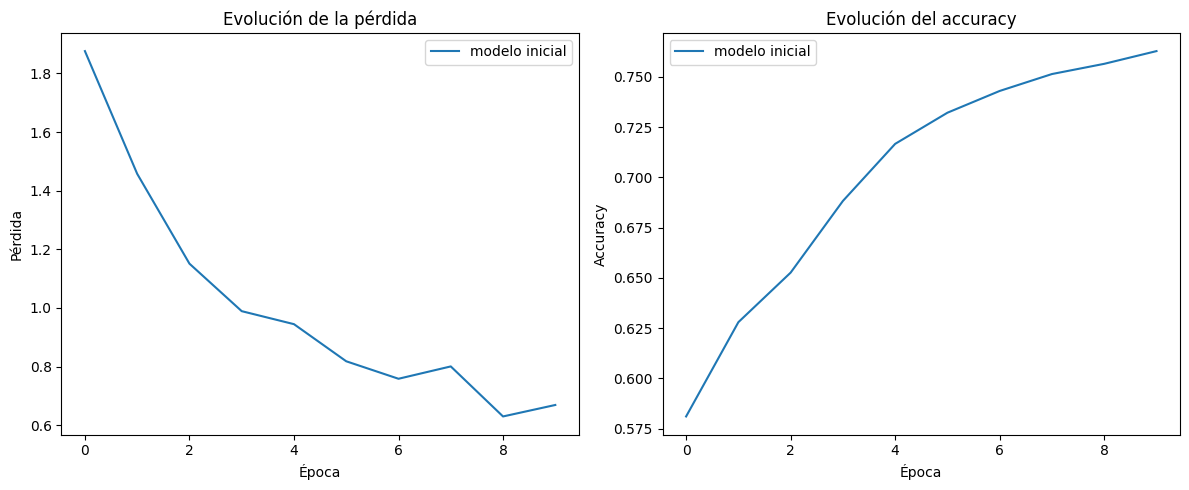

In [ ]:
# Graficamos utilizando los datos obtenidos del entrenamiento
dict_perdidas = {'modelo inicial': lista_perdida}
dict_accuracys = {'modelo inicial': lista_accuracy}
graficar_evolucion_perdida_acurracy(dict_perdidas, dict_accuracys)

En estos gráficos se puede observar de mejor manera como funciona el entrenamiento del modelo. La función de pérdida disminiuye rápidamente al inicio y luego tiende a estabilizarse a medida que es entrenado.
En el gráfico de la derecha se observa cómo al mismo tiempo aumenta el valor de accuracy y posiblemente tienda a estabilizarse.

###Pasamos a definir nuevas arquitecturas alternativas a la red neuronal base para intentar mejorar los resultados, modificando la cantidad de unidades, la cantidad de capas ocultas, diferentes funciones de activación y/o diferentes tazas de aprendizaje.

Para esta etapa, a partir del modelo inicial, se proponen cambios utilizando tres enfoques distintos:


1.   Aumentar la cantidad de capas ocultas menteniendo o disminuyendo la cantidad de neuronas totales.
2.   Aumentar y disminuir la cantidad de neuronas para la misma cantidad de capas que el modelo inicial.
3.   Utilizar otra función de activación como Tangente hiperbólica.

Para los dos primeros enfoques se realizan pruebas con distintas cantidades de neuronas y se elige la mejor opción a partir del accuracy obtenido.

Todas las opciones se prueban para distintas tasas de aprendizaje, las cuales se muestran a continuación:


In [ ]:
# Se definen las tasas de aprendizaje a probar
tasas_aprendizaje = [0.01, 0.025, 0.05, 0.075]

####Arquitectura 1

#####Definición y entrenamiento

En las arquitecturas 1, se agrega otra capa oculta a la red y se hacen tres pruebas:
Se mantiene el número total de unidades.
Se aumenta el número total de unidades.
Se disminuye el número total de unidades.

In [ ]:
def modelar_tipo_ai():
  # Modelo A: se agrega otra capa oculta aumentando número de unidades totales
  modelai = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 32),      # Capa oculta con 32 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(32, 32),         # Otra capa oculta con 32 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(32, 10))
  return modelai

def modelar_tipo_aii():
  # Se agrega capa oculta manteniendo número de unidades totales
  modelaii = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 16),      # Capa oculta con 16 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(16, 16),         # Otra capa oculta con 16 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(16, 10))
  return modelaii

def modelar_tipo_aiii():
  # Se agrega capa oculta bajando número de unidades totales
  modelaiii = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 8),       # Capa oculta con 8 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(8, 8),           # Otra capa oculta con 8 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(8, 10))
  return modelaiii

#####Entrenamiento



In [ ]:
# Realizamos el entrenamiento del modelo ai
dict_perdidas_ai = {}
dict_accuracys_ai = {}
for tasa_aprendizaje in tasas_aprendizaje:
  modelai = modelar_tipo_ai()
  print(f'Accuracy para tasa de aprendizaje: {tasa_aprendizaje}')
  lista_perdida_ai, lista_accuracy_ai = train(modelai, num_epochs, tasa_aprendizaje)
  dict_perdidas_ai[f'modelo ai tasa={tasa_aprendizaje}'] = lista_perdida_ai
  dict_accuracys_ai[f'modelo ai tasa={tasa_aprendizaje}'] = lista_accuracy_ai

# Realizamos el entrenamiento del modelo aii
dict_perdidas_aii = {}
dict_accuracys_aii = {}
for tasa_aprendizaje in tasas_aprendizaje:
  modelaii = modelar_tipo_aii()
  print(f'Accuracy para tasa de aprendizaje: {tasa_aprendizaje}')
  lista_perdida_aii, lista_accuracy_aii = train(modelaii, num_epochs, tasa_aprendizaje)
  dict_perdidas_aii[f'modelo aii tasa={tasa_aprendizaje}'] = lista_perdida_aii
  dict_accuracys_aii[f'modelo aii tasa={tasa_aprendizaje}'] = lista_accuracy_aii

# Realizamos el entrenamiento del modelo aiii
dict_perdidas_aiii = {}
dict_accuracys_aiii = {}
for tasa_aprendizaje in tasas_aprendizaje:
  modelaiii = modelar_tipo_aiii()
  print(f'Accuracy para tasa de aprendizaje: {tasa_aprendizaje}')
  lista_perdida_aiii, lista_accuracy_aiii = train(modelaiii, num_epochs, tasa_aprendizaje)
  dict_perdidas_aiii[f'modelo aiii tasa={tasa_aprendizaje}'] = lista_perdida_aiii
  dict_accuracys_aiii[f'modelo aiii tasa={tasa_aprendizaje}'] = lista_accuracy_aiii

Accuracy para tasa de aprendizaje: 0.01
Epoch 0  Accuracy del conjunto de validación 0.2599
Epoch 1  Accuracy del conjunto de validación 0.2457
Epoch 2  Accuracy del conjunto de validación 0.4201
Epoch 3  Accuracy del conjunto de validación 0.2570
Epoch 4  Accuracy del conjunto de validación 0.3000
Epoch 5  Accuracy del conjunto de validación 0.3942
Epoch 6  Accuracy del conjunto de validación 0.3722
Epoch 7  Accuracy del conjunto de validación 0.4162
Epoch 8  Accuracy del conjunto de validación 0.4861
Epoch 9  Accuracy del conjunto de validación 0.5521
Accuracy para tasa de aprendizaje: 0.025
Epoch 0  Accuracy del conjunto de validación 0.3159
Epoch 1  Accuracy del conjunto de validación 0.3718
Epoch 2  Accuracy del conjunto de validación 0.4362
Epoch 3  Accuracy del conjunto de validación 0.5203
Epoch 4  Accuracy del conjunto de validación 0.5676
Epoch 5  Accuracy del conjunto de validación 0.6067
Epoch 6  Accuracy del conjunto de validación 0.6087
Epoch 7  Accuracy del conjunto de v

#####Evaluación


 Gráficas de Arquitectura 1 con 2 capas ocultas de 32 neuronas y funciones de activación sigmoide 



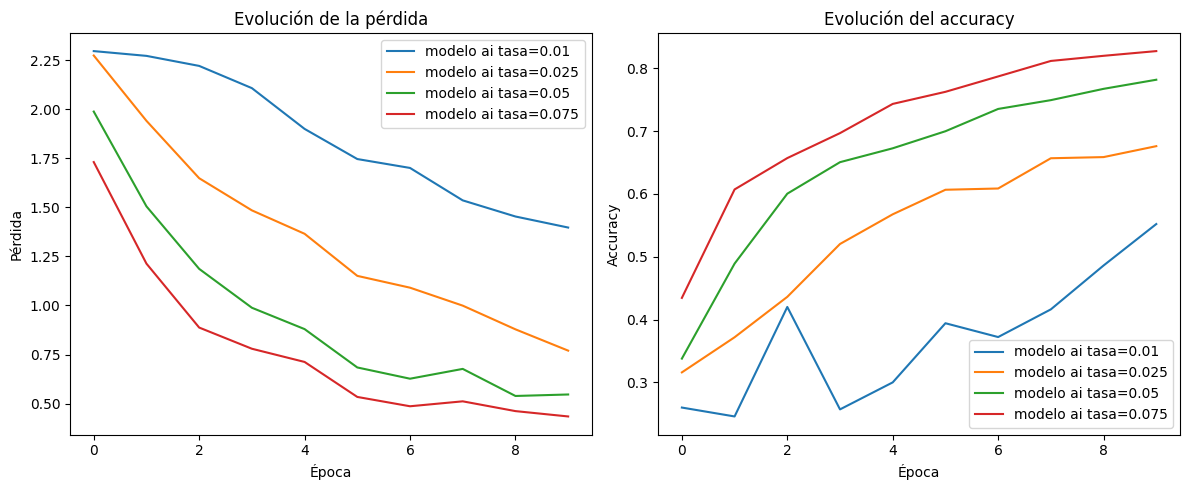


 Gráficas de Arquitectura 1 con 2 capas ocultas de 16 neuronas y funciones de activación sigmoide 



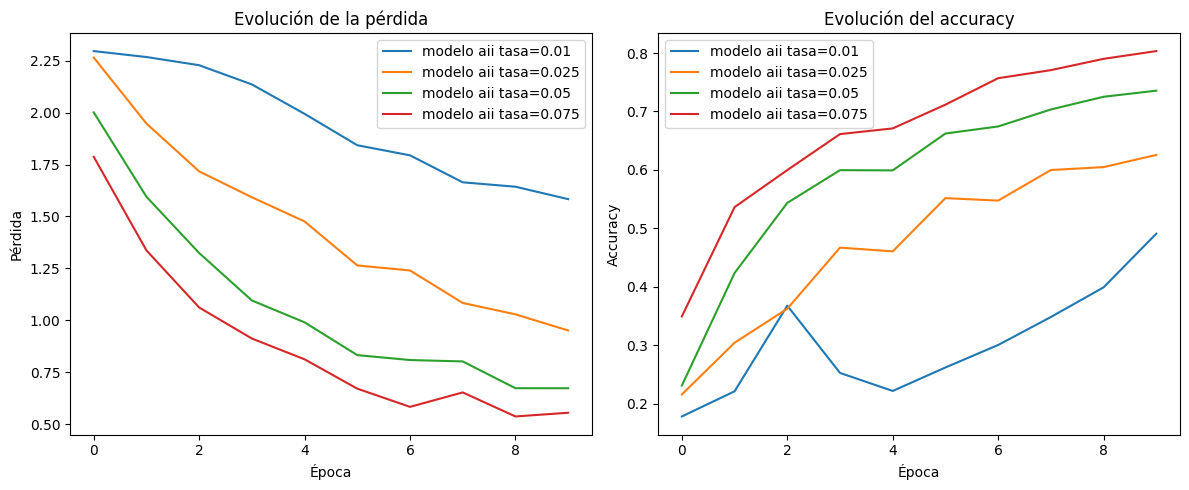


 Gráficas de Arquitectura 1 con 2 capas ocultas de 8 neuronas y funciones de activación sigmoide 



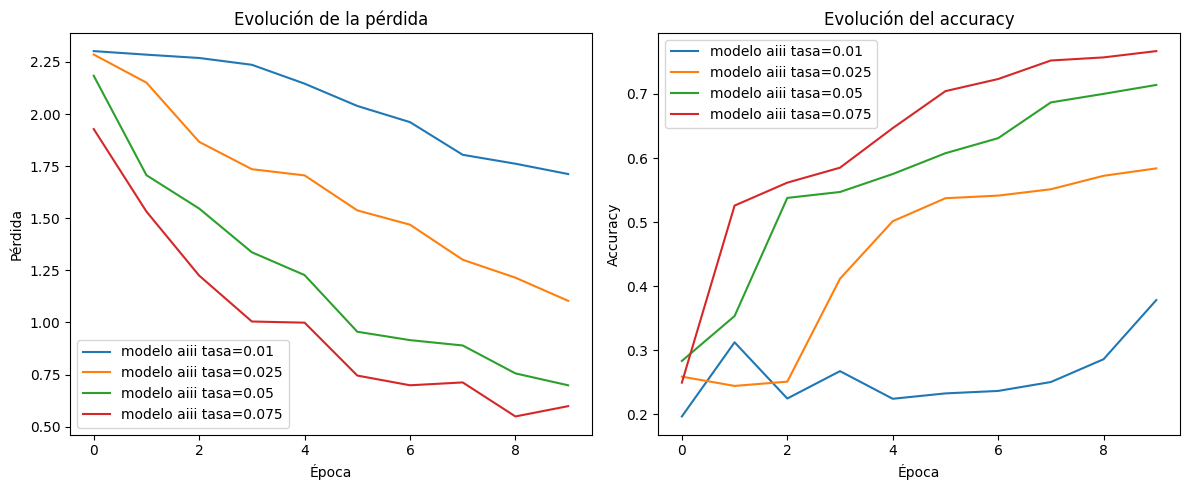

In [ ]:
print('\n', 'Gráficas de Arquitectura 1 con 2 capas ocultas de 32 neuronas y funciones de activación sigmoide', '\n')
graficar_evolucion_perdida_acurracy(dict_perdidas_ai, dict_accuracys_ai)
print('\n', 'Gráficas de Arquitectura 1 con 2 capas ocultas de 16 neuronas y funciones de activación sigmoide', '\n')
graficar_evolucion_perdida_acurracy(dict_perdidas_aii, dict_accuracys_aii)
print('\n', 'Gráficas de Arquitectura 1 con 2 capas ocultas de 8 neuronas y funciones de activación sigmoide', '\n')
graficar_evolucion_perdida_acurracy(dict_perdidas_aiii, dict_accuracys_aiii)

Se obtienen mejores resultados con una mayor tasa de aprendizaje (LR) en todos los casos (tasa de 0.075) y da mejor con el modelo ai, que consta de dos capas ocultas de 32 unidades cada una.


####Arquitectura 2

#####Definición

La arquitectura 2 se deja igual el número de capas y la función de activación pero se modifica el número total de unidades. Se hacen dos pruebas: una con 48 unidades y otra con 16.

In [ ]:
# Modelo B: se modifica número total de unidades
def modelar_tipo_bi():
  # Se aumenta número de unidades totales
  modelbi = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 48),      # Capa oculta con 48 unidades
      nn.Sigmoid(),              # Función de activación sigmoide
      nn.Linear(48, 10))
  return modelbi

def modelar_tipo_bii():
  #Bajamos número de unidades totales
  modelbii = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 16),      # Capa oculta con 16 unidades
      nn.Sigmoid(),              # Función de activación sigmoide
      nn.Linear(16, 10))
  return modelbii

##### Entrenamiento

In [ ]:
# Realizamos el entrenamiento del modelo bi
dict_perdidas_bi = {}
dict_accuracys_bi = {}
for tasa_aprendizaje in tasas_aprendizaje:
  modelbi = modelar_tipo_bi()
  print(f'Accuracy para tasa de aprendizaje: {tasa_aprendizaje}')
  lista_perdida_bi, lista_accuracy_bi = train(modelbi, num_epochs, tasa_aprendizaje)
  dict_perdidas_bi[f'modelo bi tasa={tasa_aprendizaje}'] = lista_perdida_bi
  dict_accuracys_bi[f'modelo bi tasa={tasa_aprendizaje}'] = lista_accuracy_bi

# Realizamos el entrenamiento del modelo bii
dict_perdidas_bii = {}
dict_accuracys_bii = {}
for tasa_aprendizaje in tasas_aprendizaje:
  modelbii = modelar_tipo_bii()
  print(f'Accuracy para tasa de aprendizaje: {tasa_aprendizaje}')
  lista_perdida_bii, lista_accuracy_bii = train(modelbii, num_epochs, tasa_aprendizaje)
  dict_perdidas_bii[f'modelo bii tasa={tasa_aprendizaje}'] = lista_perdida_bii
  dict_accuracys_bii[f'modelo bii tasa={tasa_aprendizaje}'] = lista_accuracy_bii

Accuracy para tasa de aprendizaje: 0.01
Epoch 0  Accuracy del conjunto de validación 0.5683
Epoch 1  Accuracy del conjunto de validación 0.6674
Epoch 2  Accuracy del conjunto de validación 0.6908
Epoch 3  Accuracy del conjunto de validación 0.7067
Epoch 4  Accuracy del conjunto de validación 0.7260
Epoch 5  Accuracy del conjunto de validación 0.7340
Epoch 6  Accuracy del conjunto de validación 0.7431
Epoch 7  Accuracy del conjunto de validación 0.7492
Epoch 8  Accuracy del conjunto de validación 0.7555
Epoch 9  Accuracy del conjunto de validación 0.7620
Accuracy para tasa de aprendizaje: 0.025
Epoch 0  Accuracy del conjunto de validación 0.6686
Epoch 1  Accuracy del conjunto de validación 0.7245
Epoch 2  Accuracy del conjunto de validación 0.7444
Epoch 3  Accuracy del conjunto de validación 0.7610
Epoch 4  Accuracy del conjunto de validación 0.7786
Epoch 5  Accuracy del conjunto de validación 0.7918
Epoch 6  Accuracy del conjunto de validación 0.8005
Epoch 7  Accuracy del conjunto de v

#####Evaluación


 Gráficas de Arquitectura 2 con 1 capa oculta de 48 neuronas y función de activación sigmoide 



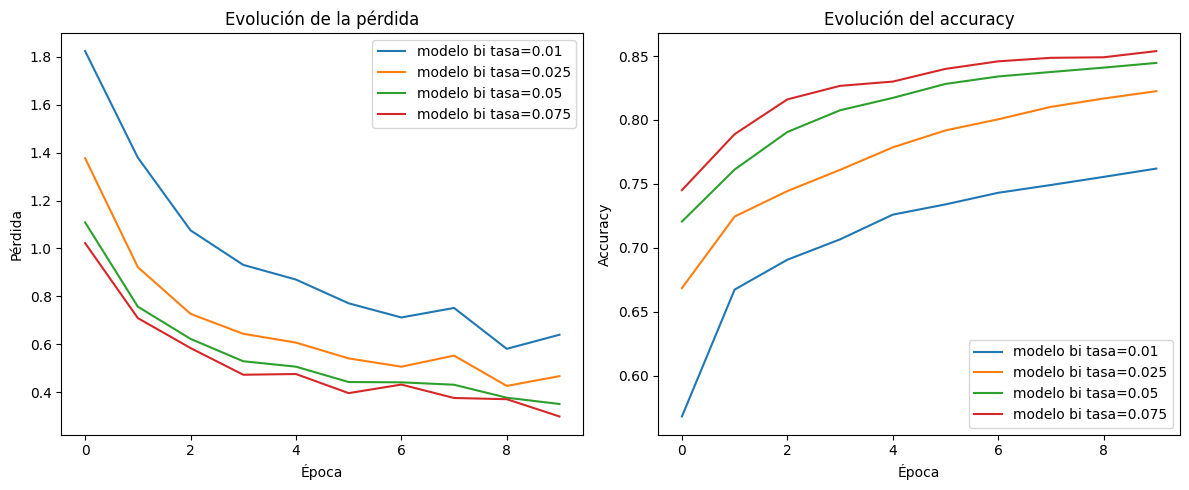


 Gráficas de Arquitectura 2 con 1 capa oculta de 16 neuronas y función de activación sigmoide 



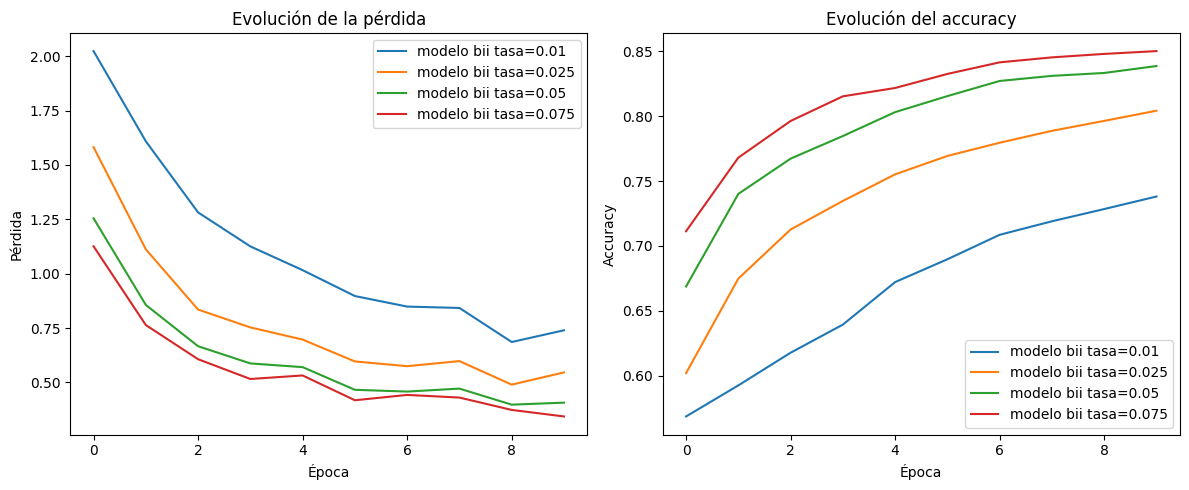

In [ ]:
print('\n', 'Gráficas de Arquitectura 2 con 1 capa oculta de 48 neuronas y función de activación sigmoide', '\n')
graficar_evolucion_perdida_acurracy(dict_perdidas_bi, dict_accuracys_bi)
print('\n', 'Gráficas de Arquitectura 2 con 1 capa oculta de 16 neuronas y función de activación sigmoide', '\n')
graficar_evolucion_perdida_acurracy(dict_perdidas_bii, dict_accuracys_bii)

Como puede verse, también dan mejores las pruebas con LR de 0.075 y dan resultados similares las pruebas con 16 y con 48 neuronas, con una accuracy levemente mejor para la prueba con 48 unidades.


####Arquitectura 3

#####Definición

En esta arquitectura se prueba a cambiar (respecto al modelo inicial) la función de activación (cambiamos la sigmoide por la función tangente hiperbólica) y aumentamos la cantidad de neuronas a 48.


In [ ]:
# Modelo C: modificamos la cantidad de capas de 48 neuronas y sus funciones de activación
def modelar_tipo_c():

  modelc = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 48),
      nn.Tanh(),
      nn.Linear(48, 10)
  )
  return modelc

##### Entrenamiento

In [ ]:
# Realizamos el entrenamiento del modelo c
dict_perdidas_c = {}
dict_accuracys_c = {}
for tasa_aprendizaje in tasas_aprendizaje:
  modelc = modelar_tipo_c()
  print(f'Accuracy para tasa de aprendizaje: {tasa_aprendizaje}')
  lista_perdida_c, lista_accuracy_c = train(modelc, num_epochs, tasa_aprendizaje)
  dict_perdidas_c[f'modelo c tasa={tasa_aprendizaje}'] = lista_perdida_c
  dict_accuracys_c[f'modelo c tasa={tasa_aprendizaje}'] = lista_accuracy_c

Accuracy para tasa de aprendizaje: 0.01
Epoch 0  Accuracy del conjunto de validación 0.7086
Epoch 1  Accuracy del conjunto de validación 0.7699
Epoch 2  Accuracy del conjunto de validación 0.7971
Epoch 3  Accuracy del conjunto de validación 0.8106
Epoch 4  Accuracy del conjunto de validación 0.8197
Epoch 5  Accuracy del conjunto de validación 0.8253
Epoch 6  Accuracy del conjunto de validación 0.8316
Epoch 7  Accuracy del conjunto de validación 0.8348
Epoch 8  Accuracy del conjunto de validación 0.8385
Epoch 9  Accuracy del conjunto de validación 0.8425
Accuracy para tasa de aprendizaje: 0.025
Epoch 0  Accuracy del conjunto de validación 0.7727
Epoch 1  Accuracy del conjunto de validación 0.8188
Epoch 2  Accuracy del conjunto de validación 0.8319
Epoch 3  Accuracy del conjunto de validación 0.8397
Epoch 4  Accuracy del conjunto de validación 0.8419
Epoch 5  Accuracy del conjunto de validación 0.8498
Epoch 6  Accuracy del conjunto de validación 0.8533
Epoch 7  Accuracy del conjunto de v

#####Evaluación


 Gráficas de Arquitectura 3 con 1 capa oculta de 48 neuronas y función de activación Tanh 



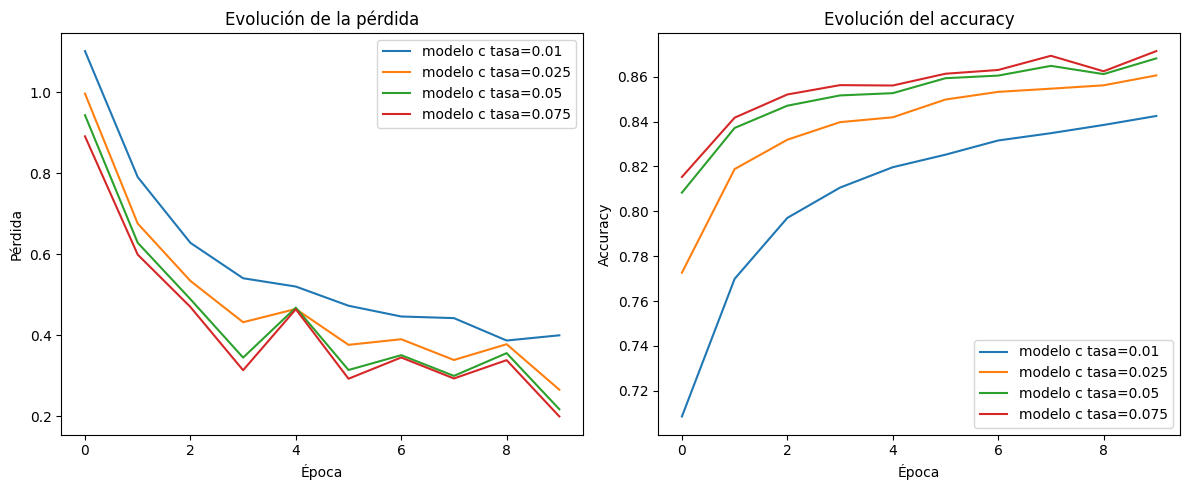

In [ ]:
print('\n', 'Gráficas de Arquitectura 3 con 1 capa oculta de 48 neuronas y función de activación Tanh', '\n')
graficar_evolucion_perdida_acurracy(dict_perdidas_c, dict_accuracys_c)

#####Evaluación de las 3 arquitecturas

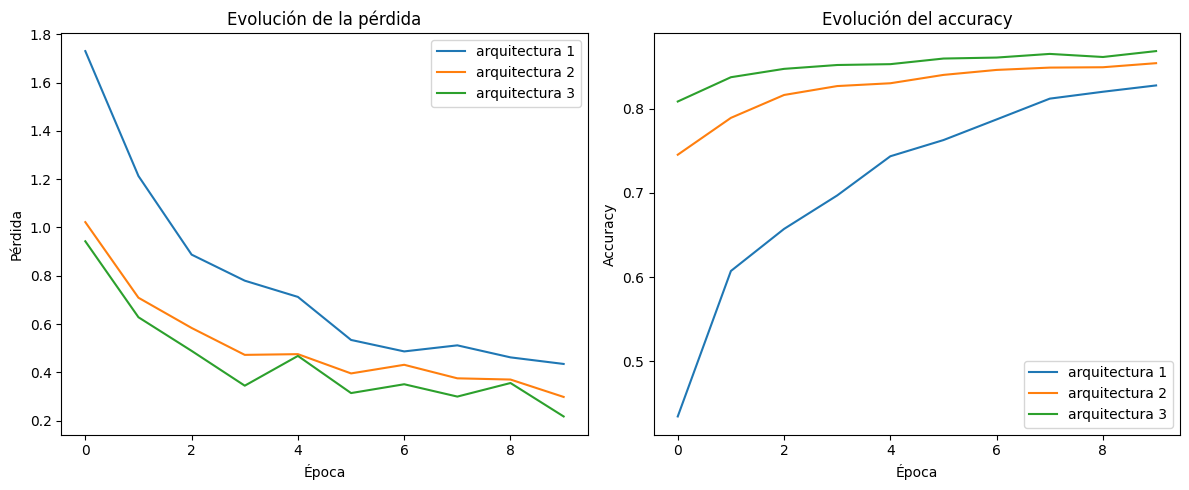

In [ ]:
dict_perdidas_distintas_arquitecturas = {'arquitectura 1': dict_perdidas_ai[f'modelo ai tasa={0.075}'], 'arquitectura 2': dict_perdidas_bi[f'modelo bi tasa={0.075}'], 'arquitectura 3': dict_perdidas_c[f'modelo c tasa={0.05}']}
dict_accuracys_distintas_arquitecturas = {'arquitectura 1': dict_accuracys_ai[f'modelo ai tasa={0.075}'], 'arquitectura 2': dict_accuracys_bi[f'modelo bi tasa={0.075}'], 'arquitectura 3': dict_accuracys_c[f'modelo c tasa={0.05}']}
graficar_evolucion_perdida_acurracy(dict_perdidas_distintas_arquitecturas, dict_accuracys_distintas_arquitecturas)

Esta es la arquitectura que funciona mejor, además podemos decir que funciona mejor con LR más altas (de 0.05 o 0.075). Para las pruebas posteriores consideraremos esta arquitectura con una LR de 0.05, por considerar que aprende suficientemente rápido y no tiene una tasa de aprendizaje muy grande que genere los picos que puedan notarse en las gráficas de exactitud.

Por lo tanto, a partir de las evaluaciones con las distinas arquitecturas, se elige la arquitectura 3, es decir, la que utiliza la función de activación tangente hiperbólica.

Otro factor a destacar es como van cambiando las curvas de la gráfica de Pérdida y de Exactitud en función de las épocas de entrenamiento en la medida que modificamos las tasas de apredizaje. Lo que se observa es que para tasas de aprendizaje pequeñas, el algoritmo de búsqueda es más lento, tomándole más iteraciones para llegar al mismo valor de Pérdida o de Exactitud que para valores más elevados de tasa de aprendizaje. Sin embargo, la curvas con tasas de aprendizaje pequeñas son muchos más suaves, ya que si vienen tarda más en hallar el mínimo local por dar pasos pequeños, al dar pasos pequeños diminuís el riesgo de "pasarte para el otro lado" (digamos, de moverte tanto en un sentido que ya la función deje de decrecer). Cuando la tasa de aprendizaje es muy grande, se llega más rapidamente a mejores valores de Pérdida y Exactitudpero te expones mucho más a "pasarte para el otro lado", como pasa en la época 4.

###A partir del mejor modelo obtenido (la arquitectura 3), se evalúa el modelo sobre el conjunto de validación al aplicar el mecanismo de regularización Dropout.

#####Definición

In [ ]:
def modelar_tipo_c_dropout(dropout_prob):

  modelc_dropout = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 48),
      nn.Tanh(),
      nn.Dropout(p=dropout_prob),
      nn.Linear(48, 10)
  )
  return modelc_dropout

#####Entrenamiento

In [ ]:
# Se define probabilidad de dropout
dropout_prob = 0.2
# Realizamos el entrenamiento del modelo c con Dropout
for tasa_aprendizaje in tasas_aprendizaje:
  modelc_dropout = modelar_tipo_c_dropout(dropout_prob)
  print(f'Accuracy para tasa de aprendizaje: {tasa_aprendizaje}')
  lista_perdida_c_dropout, lista_accuracy_c_dropout = train(modelc_dropout, num_epochs, tasa_aprendizaje)
  dict_perdidas_distintas_arquitecturas[f'modelo c con Dropout tasa={tasa_aprendizaje}'] = lista_perdida_c_dropout
  dict_accuracys_distintas_arquitecturas[f'modelo c con Dropout tasa={tasa_aprendizaje}'] = lista_accuracy_c_dropout

Accuracy para tasa de aprendizaje: 0.01
Epoch 0  Accuracy del conjunto de validación 0.6931
Epoch 1  Accuracy del conjunto de validación 0.7540
Epoch 2  Accuracy del conjunto de validación 0.7799
Epoch 3  Accuracy del conjunto de validación 0.7962
Epoch 4  Accuracy del conjunto de validación 0.8159
Epoch 5  Accuracy del conjunto de validación 0.8177
Epoch 6  Accuracy del conjunto de validación 0.8259
Epoch 7  Accuracy del conjunto de validación 0.8242
Epoch 8  Accuracy del conjunto de validación 0.8340
Epoch 9  Accuracy del conjunto de validación 0.8334
Accuracy para tasa de aprendizaje: 0.025
Epoch 0  Accuracy del conjunto de validación 0.7739
Epoch 1  Accuracy del conjunto de validación 0.8049
Epoch 2  Accuracy del conjunto de validación 0.8235
Epoch 3  Accuracy del conjunto de validación 0.8348
Epoch 4  Accuracy del conjunto de validación 0.8353
Epoch 5  Accuracy del conjunto de validación 0.8387
Epoch 6  Accuracy del conjunto de validación 0.8401
Epoch 7  Accuracy del conjunto de v

#####Evaluación

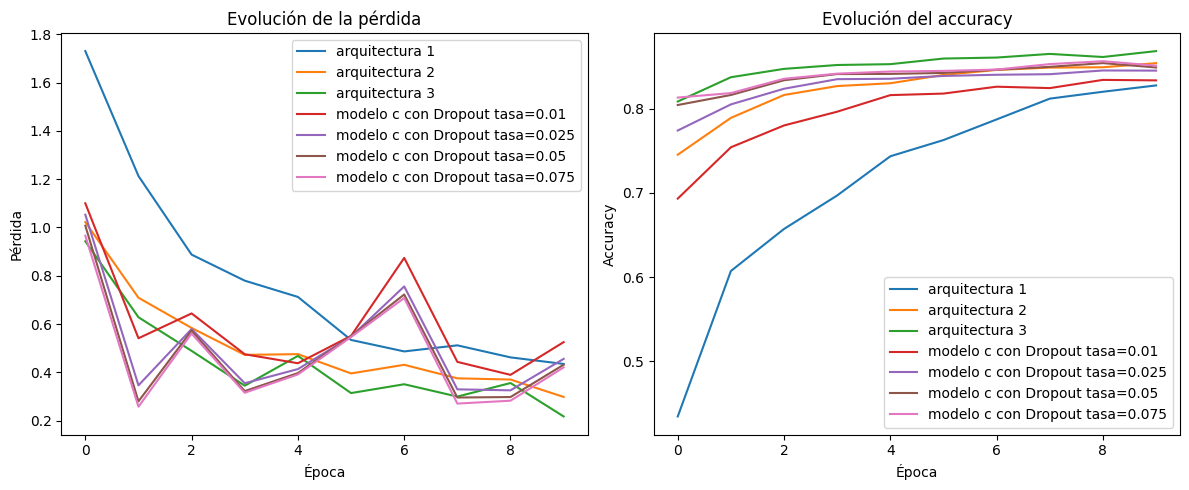

In [ ]:
graficar_evolucion_perdida_acurracy(dict_perdidas_distintas_arquitecturas, dict_accuracys_distintas_arquitecturas)

Se comparan los resultados con los obtenidos para las tres primeras arquitecturas y si bien arroja resultados un poco más bajos que la arquitectura 3 sin dropout, se decide utilizarla con el mecanismo de regularización ya que previene el sobreajuste.

###A continuación evaluamos la performance sobre el conjunto de evaluación utilizando accuracy, precision, recall y medida F1 para cada una de las clases. Además, se construye la matriz de confusión:

####Función para generar matriz de confusión

In [ ]:
def mostrar_matriz_confusion(matriz_confusion):

  # Calcula los porcentajes dividiendo cada valor en la matriz de confusión por el total de la fila correspondiente
  matriz_confusion_porcentaje = matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis]

  plt.imshow(matriz_confusion_porcentaje, cmap='Purples')

  # Configura el formato de los valores de la matriz como porcentajes
  fmt = '.2f'
  thresh = matriz_confusion_porcentaje.max() / 2.
  for i in range(matriz_confusion_porcentaje.shape[0]):
    for j in range(matriz_confusion_porcentaje.shape[1]):
        plt.text(j, i, format(matriz_confusion_porcentaje[i, j], fmt), ha="center", va="center", color="white" if matriz_confusion_porcentaje[i, j] > thresh else "black")

  # Etiquetas
  etiquetas = range(10)

  # Establece los ticks personalizados y las etiquetas para los ejes x e y
  plt.xticks(np.arange(len(etiquetas)), etiquetas)
  plt.yticks(np.arange(len(etiquetas)), etiquetas)


  plt.title('Matriz de Confusión')
  plt.xlabel('Etiqueta Predicha')
  plt.ylabel('Etiqueta Real')

  plt.colorbar()
  plt.show()

#### Evaluación con el conjunto de testeo

Accuracy para tasa de aprendizaje: 0.075
Epoch 0  Accuracy del conjunto de validación 0.8058
Epoch 1  Accuracy del conjunto de validación 0.8163
Epoch 2  Accuracy del conjunto de validación 0.8408
Epoch 3  Accuracy del conjunto de validación 0.8462
Epoch 4  Accuracy del conjunto de validación 0.8501
Epoch 5  Accuracy del conjunto de validación 0.8449
Epoch 6  Accuracy del conjunto de validación 0.8496
Epoch 7  Accuracy del conjunto de validación 0.8496
Epoch 8  Accuracy del conjunto de validación 0.8547
Epoch 9  Accuracy del conjunto de validación 0.8556
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      1000
           1       0.98      0.96      0.97      1000
           2       0.71      0.79      0.75      1000
           3       0.88      0.83      0.85      1000
           4       0.75      0.73      0.74      1000
           5       0.93      0.92      0.93      1000
           6       0.68      0.51      0.58      1000
      

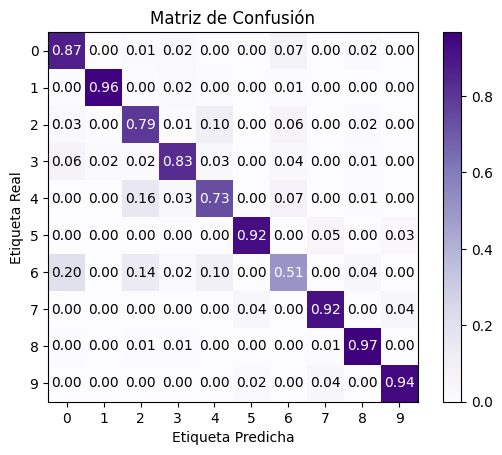

In [ ]:
# Predecimos utilizando el modelo
modelo_definitivo = modelar_tipo_c_dropout(dropout_prob)
print(f'Accuracy para tasa de aprendizaje: {tasa_aprendizaje}')
# Entrenamos el modelo
lista_perdida_def, lista_accuracy_def = train(modelo_definitivo, num_epochs, 0.075)
# Antes normalizamos los valores RGB
# Esto lo hago porque no paso por el transform
predicciones = modelo_definitivo(fashionmnist_test_dataset.data/255.)
predicciones = torch.argmax(predicciones,dim=1).numpy()

valores_reales = fashionmnist_test_dataset.targets.numpy()

print(metrics.classification_report(valores_reales, predicciones))
mostrar_matriz_confusion(metrics.confusion_matrix(valores_reales, predicciones))

Como puede verse con la matriz de confusión, las etiquetas con las que más se  equivoca el modelo son la 2 y la 6.
Las imágenes con etiqueta 2 mal etiquetadas son principalmente etiquetadas como 4 y como 6. Por otro lado, las imágenes con etiqueta 6 mal clasificadas suelen ser etiquetadas como imágenes del grupo 6, del grupo 1 y del grupo 4.
A continuación se muestra una tabla con que prenda es cada categoría de imágenes:

        Label	   Description
          0	     Camiseta/top
          1	      Pantalón
          2	      Pullover
          3	       Vestido
          4           Abrigo
          5	      Sandalia
          6	       Camisa
          7     Calzado de deporte
          8	        Bolso
          9	        Botín

Comparando con los resultados reportados en el sitio del dataset, vemos que son bastante similares. Al usar redes con funciones de activación del tipo tangente hiperbólica logran exactitudes  de 84.0% a 87.0%, el valor obtenido por nosotros se encuentra dentro de este rango (84%) con un número de épocas mayor al que usan ellos (10 contra 5). Para esta parte utilizamos dropout, lo que arroja una exactitud algo menor que sin dropout. Es posible que si modificamos el factor de propout puedan mejorar estos valores. Además, con el número de épocas consideradas en estas pruebas no se observó que se estuviese dando overfitting en el entrenamiento (porque en el conjunto de validación la exactitud continuaba aumentando con cada época).

###Por último, resulta interesante ver cuáles son las as diez instancias del conjunto de evaluación más “difíciles” para el clasificador construido. Para esto, se utiliza como medida la entropía:

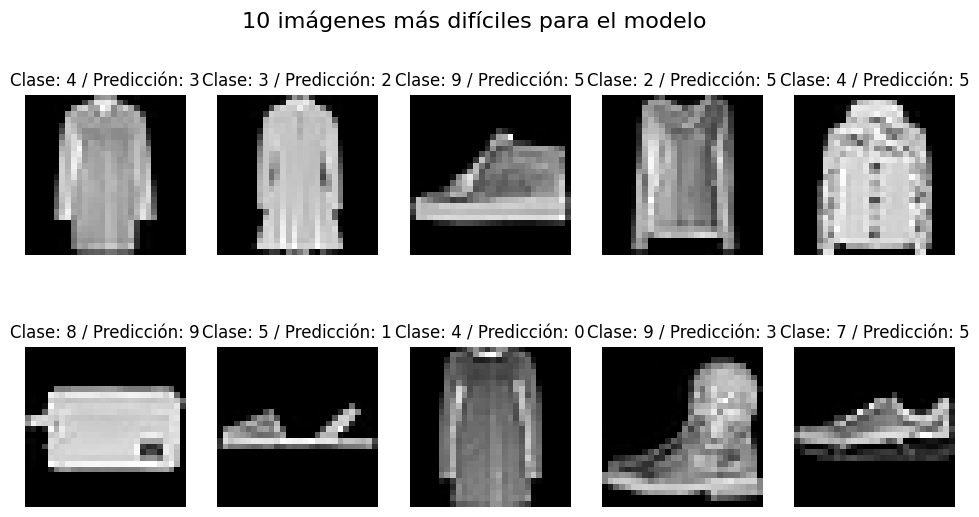

In [ ]:
import torch.nn.functional as F
# Evaluamos en el conjunto de testeo
test_dl = DataLoader(fashionmnist_test_dataset, batch_size, shuffle=True)

# Evaluar el modelo en el conjunto de prueba
predicciones = []  # Almacena las predicciones del modelo
valores_reales = []  # Almacena las etiquetas reales

# Calcula las entropías de las predicciones
entropias = []

# Evaluar el modelo en el conjunto de prueba
with torch.no_grad():  # Desactiva el cálculo de gradientes
    for imagenes, etiquetas in test_dl:
        outputs = modelo_definitivo(imagenes)
        _, predicted = torch.max(outputs.data, 1)
        predicciones.extend(predicted.tolist())
        valores_reales.extend(etiquetas.tolist())

        # Calcula la entropía de las predicciones
        entropy = F.cross_entropy(outputs, etiquetas)
        entropias.append(entropy)

# Encuentra los índices de las 10 instancias más difíciles de clasificar
top_difficult_indices = torch.argsort(torch.tensor(entropias), descending=True)[:10]

# Muestra las imágenes y sus etiquetas correspondientes
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("10 imágenes más difíciles para el modelo", fontsize=16)
i = 0
for index in top_difficult_indices:
    image, true_label = fashionmnist_test_dataset[index]
    ax = axes[i // 5, i % 5]
    ax.imshow(image.squeeze(), cmap='gray')
    # = torch.argmax(modelo_definitivo(image), dim=1).item()
    ax.set_title(f'Clase: {true_label} / Predicción: {predicciones[index]}')
    ax.axis('off')
    i = i + 1
plt.show()

Vemos que las mayoría de las imágenes más difíciles de clasificar son vestidos/remeras y botines u otros calzados. Además vemos que las imágenes en cuestión tienen pixeles bastante similares, es decir, las prendas están formadas por píxeles de mas o menos el mismo tono y admás son prendas ambiguas, o sea que ni si quiera nosotros estamos seguros de como clasificarlas.
Vemos que las mayoría de las imágenes más difíciles de clasificar son vestidos/remeras y botines u otros calzados. Además vemos que las imágenes en cuestión tienen pixeles bastante similares, es decir, las prendas están formadas por píxeles de mas o menos el mismo tono y admás son prendas ambiguas, o sea que ni si quiera nosotros estamos seguros de como clasificarlas.